In [2]:
!pip install transformers tensorflow datasets kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 102.1 MB/s eta 0:00:00 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 264.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 237.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 436.1/436.1 kB 304.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 782.0/782.0 kB 204.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 436.4/436.4 kB 299.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 260.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 271.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.9/193.9 kB 263.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 256.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.2/78.2 kB 246.0 MB/s eta 0:00:00
  Created wheel for kaggle: filename=kaggle-1.6.17-py3-none-an

In [1]:
!if [ ! -e ~/.kaggle/kaggle.json ]; then mkdir -p ~/.kaggle; cp ~/kaggle.json ~/.kaggle; echo "Copied"; fi
!chmod 600 ~/.kaggle/kaggle.json
!ls -alR ~/.kaggle

/opt/app-root/src/.kaggle:
total 12
drwxrwsr-x.  2 1006090000 1006090000 4096 Oct  5 08:28 .
drwxrwsr-x. 14 root       1006090000 4096 Oct  6 10:42 ..
-rw-------.  1 1006090000 1006090000   69 Oct  5 08:28 kaggle.json


In [3]:
# https://nihcc.app.box.com/v/ChestXray-NIHCC

#kaggle datasets list
!mkdir -p models
!rm -rf chest_xray
!kaggle datasets download paultimothymooney/chest-xray-pneumonia
!if [ ! -d chest_xray.dataset ]; then unzip -q chest-xray-pneumonia.zip; mv chest_xray chest_xray.dataset; fi
!rm -rf chest_xray.dataset/__MACOSX
!echo "Download complete"

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)
Download complete


In [4]:
import tensorflow as tf
#from sklearn.model_selection import train_test_split

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)
    
print(tf.__version__)

2024-10-06 10:46:19.825263: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-06 10:46:19.825326: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-06 10:46:19.826970: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-06 10:46:19.835077: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-06 10:46:20.853001: W tensorflow/comp

Number of replicas: 1
2.15.1


In [5]:
INPUT_SIZE=(228,228) # use the same pixel h * w target size for all images processed
MODEL_INPUT_SHAPE=(228,228,3)

vgg_base = tf.keras.applications.VGG19(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=MODEL_INPUT_SHAPE,
    pooling=None,
    classes=1000,
    classifier_activation='softmax'
)

print('VGG19 Loaded')
print(vgg_base.summary())

VGG19 Loaded
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 228, 228, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 228, 228, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 228, 228, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 114, 114, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 114, 114, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 114, 114, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 57, 57, 128)

In [6]:
# Get model to output 3D feature maps (height, width, features)
altmodel = tf.keras.models.Sequential()

# Layer 1
altmodel.add(tf.keras.layers.Conv2D(32, (3, 3), input_shape=MODEL_INPUT_SHAPE))
altmodel.add(tf.keras.layers.Activation('relu'))
altmodel.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Layer 2
altmodel.add(tf.keras.layers.Conv2D(32, (3, 3)))
altmodel.add(tf.keras.layers.Activation('relu'))
altmodel.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Layer 3
altmodel.add(tf.keras.layers.Conv2D(64, (3, 3)))
altmodel.add(tf.keras.layers.Activation('relu'))
altmodel.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Apply flattening function to convert 3D feature maps in to 1D feature vectors
altmodel.add(tf.keras.layers.Flatten())  

# Add 2 final dense layers to add a classifier to the convolutional base
altmodel.add(tf.keras.layers.Dense(64))
altmodel.add(tf.keras.layers.Activation('relu'))
altmodel.add(tf.keras.layers.Dropout(0.5))
altmodel.add(tf.keras.layers.Dense(1))
altmodel.add(tf.keras.layers.Activation('sigmoid'))

# Compile the model
altmodel.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# Print model summary
print(altmodel.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 226, 226, 32)      896       
                                                                 
 activation (Activation)     (None, 226, 226, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 113, 113, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 111, 111, 32)      9248      
                                                                 
 activation_1 (Activation)   (None, 111, 111, 32)      0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 55, 55, 32)        0         
 g2D)                                                   

Processing chest_xray.dataset/val...
Listing chest_xray.dataset/val/NORMAL
Sample NORMAL2-IM-1442-0001.jpeg


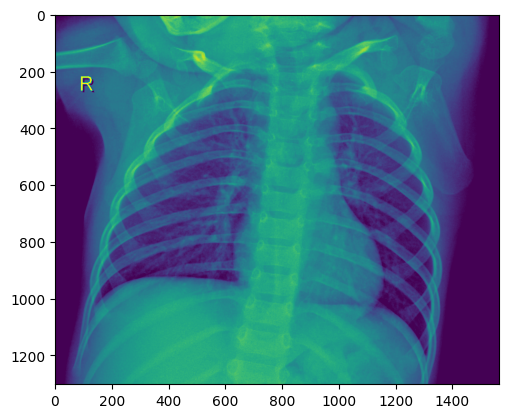

Sample NORMAL2-IM-1436-0001.jpeg


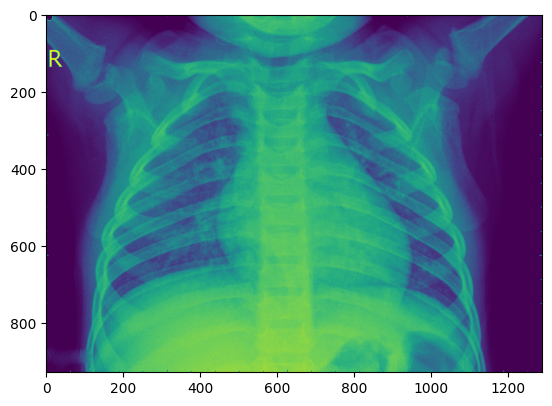

Listing chest_xray.dataset/val/PNEUMONIA
Sample person1952_bacteria_4883.jpeg


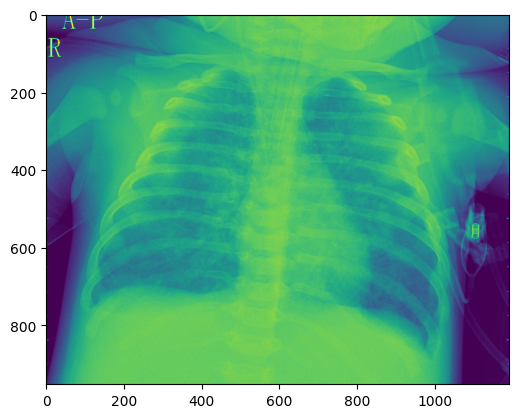

Sample person1954_bacteria_4886.jpeg


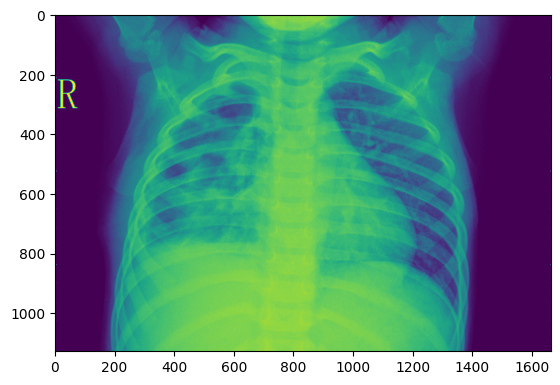

Found 16 images belonging to 2 classes.


2024-10-06 10:48:05.005884: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 212926464 exceeds 10% of free system memory.
2024-10-06 10:48:05.101688: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 212926464 exceeds 10% of free system memory.
2024-10-06 10:48:05.487689: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 106463232 exceeds 10% of free system memory.
2024-10-06 10:48:05.600633: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 106463232 exceeds 10% of free system memory.


1/1 [==============================] - 3s 3s/step
Processing chest_xray.dataset/train...
Listing chest_xray.dataset/train/NORMAL
Sample IM-0755-0001.jpeg


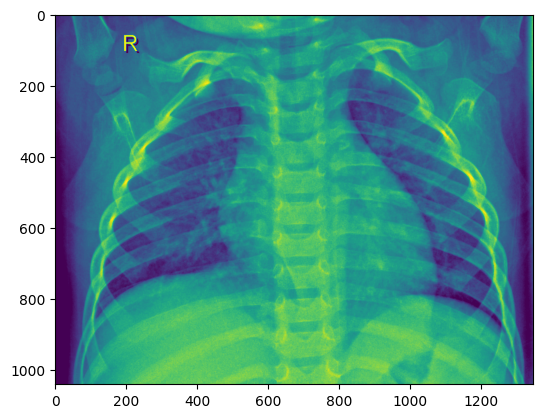

Sample IM-0318-0001.jpeg


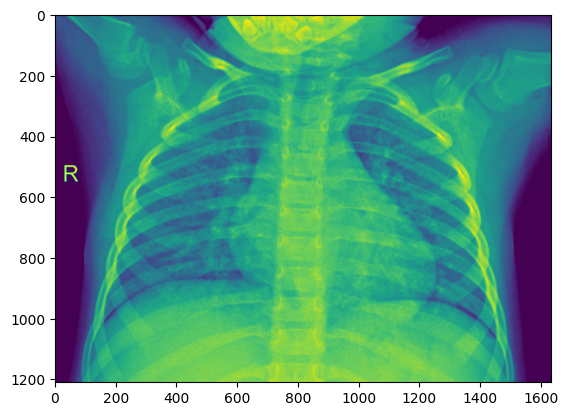

Listing chest_xray.dataset/train/PNEUMONIA
Sample person642_virus_1223.jpeg


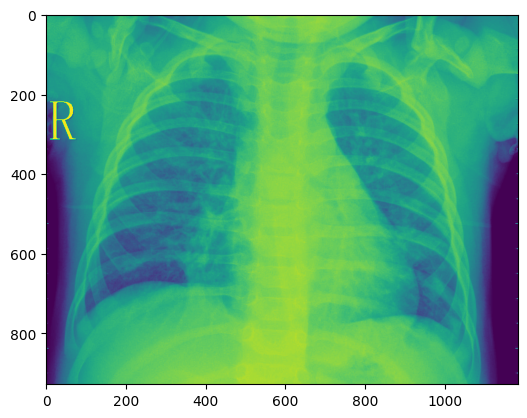

Sample person1544_virus_2685.jpeg


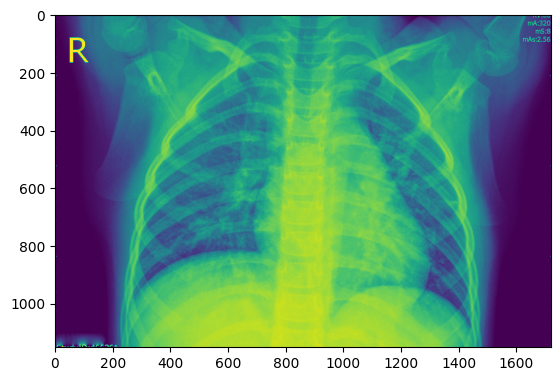

Found 5216 images belonging to 2 classes.


2024-10-06 10:48:09.852946: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 425852928 exceeds 10% of free system memory.


2/2 [==============================] - 9s 3s/step
Processing chest_xray.dataset/test...
Listing chest_xray.dataset/test/NORMAL
Sample NORMAL2-IM-0066-0001.jpeg


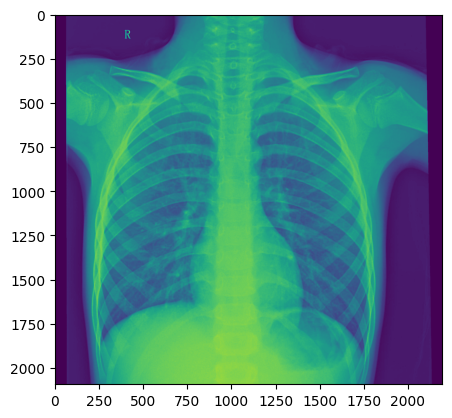

Sample NORMAL2-IM-0274-0001.jpeg


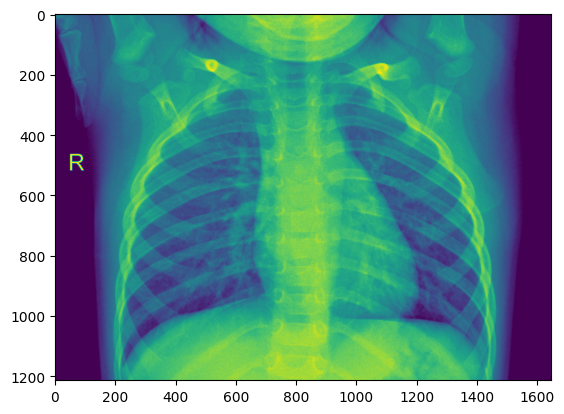

Listing chest_xray.dataset/test/PNEUMONIA
Sample person96_bacteria_465.jpeg


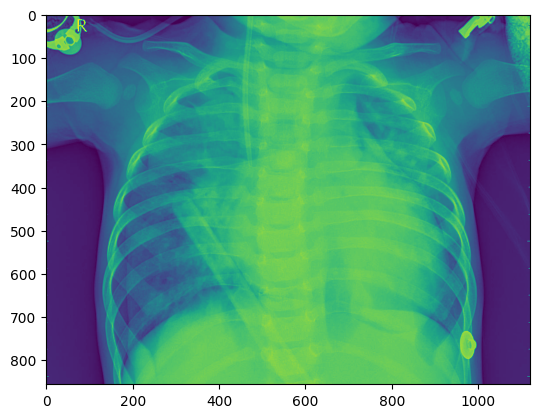

Sample person1656_virus_2862.jpeg


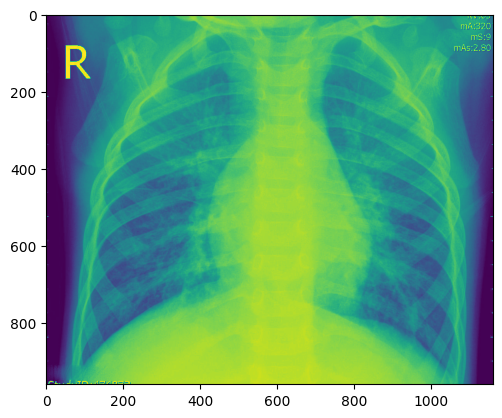

Found 624 images belonging to 2 classes.
1/1 [==============================] - 4s 4s/step
Complete


In [7]:
import os, matplotlib, numpy
import matplotlib.image, matplotlib.pyplot

# Specify dataset size
DEFAULT_BATCH_SIZE = 50
DEFAULT_EPOCHS = 10 # 30

# Specify reference for directory paths
dataset_root = "chest_xray.dataset"
classifications = [ "NORMAL", "PNEUMONIA" ]
folders = [ "val", "train", "test" ]

def show_image(filename):
    img = matplotlib.image.imread(filename)
    matplotlib.pyplot.imshow(img)
    matplotlib.pyplot.show()    

#def preprocess_data(examples):
def dataset_size(directory, labels, showSample=False):
    size = 0 
    for label in labels:
        path = "{}/{}".format(directory, label)
        print("Listing {}".format(path))
        contents = os.listdir(path)
        size += len(contents)
        if showSample:
            for pic_file in  numpy.random.choice(contents, 2):
                print("Sample {}".format(pic_file))
                show_image("{}/{}".format(path,pic_file))
    return size    

def extract_features(directory, sample_amount, batch_size=0):
    if batch_size < 1:
        batch_size = DEFAULT_BATCH_SIZE

    features = numpy.zeros(shape=(sample_amount, 7, 7, 512)) 
    labels = numpy.zeros(shape=(sample_amount))
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255) 
    generator = datagen.flow_from_directory(
        directory, target_size=INPUT_SIZE, 
        batch_size = batch_size, 
        class_mode='binary')

    i = 0
    for inputs_batch, labels_batch in generator:
        print("Inputs: {}".format(inputs_batch))
        print("Labels: {}".format(labels_batch))
        features_batch = vgg_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch 
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i = i + 1
        if i * batch_size >= sample_amount:
            break
    return features, labels

# Apply extraction function to 3 datasets
dataset = {}
dataset['features'] = {}
dataset['labels'] = {}

for folder in folders:
    path = "{}/{}".format(dataset_root, folder)
    print("Processing {}...".format(path))
    num_samples = dataset_size(path, classifications, True)
    features, labels = extract_features(path, min(1000, num_samples))
    dataset['features'][folder] = features
    dataset['labels'][folder] = labels

print("Complete")


In [8]:
# Shape data
reshape_y = 7 * 7 * 512
for folder in folders:
    print("Reprocessing {}...".format(folder))
    dataset['features'][folder] = numpy.reshape(dataset['features'][folder], (len(dataset['features'][folder]), reshape_y))

print("Complete")

Reprocessing val...
Reprocessing train...
Reprocessing test...
Complete


In [9]:
# Define size
batch_size = 16 # Batch size defines the number of samples that will be propagated through the network

# Configure augmentation for training adversity
# ImageDataGenerator rescales the pixels between zero and one
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# Set augmentation for testing
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

generators = {}
for folder in folders:
    # Read pictures in 'data/train' directory and generate batches of image data with binary labels
    path = "{}/{}".format(dataset_root, folder)
    print("Processing {}...".format(path))
    generator = train_datagen.flow_from_directory(
        path,  
        target_size=INPUT_SIZE,
        batch_size=batch_size,
        class_mode='binary')
    generators[folder] = generator

print("Complete")

Processing chest_xray.dataset/val...
Found 16 images belonging to 2 classes.
Processing chest_xray.dataset/train...
Found 5216 images belonging to 2 classes.
Processing chest_xray.dataset/test...
Found 624 images belonging to 2 classes.
Complete


In [22]:
# Set stop to 5 epochs
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    restore_best_weights=True,
    patience=5
)

# Warning: the step below takes ~40min.

# Save weights after implemeting callback to later compare
history = altmodel.fit(
        generators['train'],
        steps_per_epoch=2084 // batch_size, # 2084 is train generator result
        epochs=DEFAULT_EPOCHS, # num of epochs will dictate speed of model
        validation_data=generators['test'], # the val portion of the dataset is too small to produce val_* readings
        validation_steps=167 // batch_size, # 167 is validation generator result
        callbacks=[callback]
)
# Create directory to save results
#os.mkdir('models')
altmodel.save('models/model_01.keras')

Epoch 1/10
130/130 [==============================] - 70s 540ms/step - loss: 0.1631 - accuracy: 0.9433 - val_loss: 0.9982 - val_accuracy: 0.8250
Epoch 2/10
130/130 [==============================] - 70s 540ms/step - loss: 0.1777 - accuracy: 0.9351 - val_loss: 0.5819 - val_accuracy: 0.8313
Epoch 3/10
130/130 [==============================] - 70s 539ms/step - loss: 0.1610 - accuracy: 0.9471 - val_loss: 0.4449 - val_accuracy: 0.8500
Epoch 4/10
130/130 [==============================] - 70s 539ms/step - loss: 0.1681 - accuracy: 0.9466 - val_loss: 0.7790 - val_accuracy: 0.8000
Epoch 5/10
130/130 [==============================] - 70s 537ms/step - loss: 0.1603 - accuracy: 0.9476 - val_loss: 0.4996 - val_accuracy: 0.8250
Epoch 6/10
130/130 [==============================] - 70s 540ms/step - loss: 0.1684 - accuracy: 0.9394 - val_loss: 0.6166 - val_accuracy: 0.8500
Epoch 7/10
130/130 [==============================] - 70s 538ms/step - loss: 0.1371 - accuracy: 0.9529 - val_loss: 0.6278 - val_ac

{'verbose': 1, 'epochs': 10, 'steps': 130}


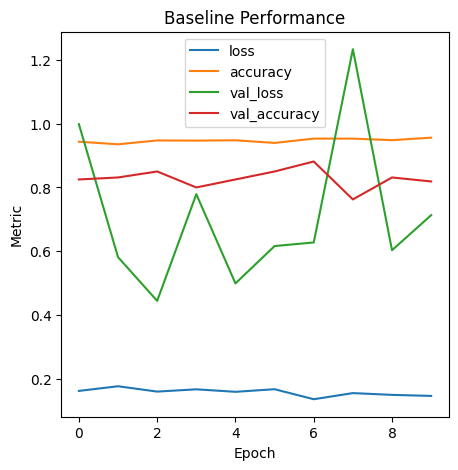

In [28]:
import pandas

print(history.params)

# Plot model training performance
    
# Useful when there wasn't enough data for the *_acc keys, pyplot requires 
# all rows to have the same number of keys
# df = pandas.DataFrame(data=history.history, columns=['loss', 'accuracy'])
df = pandas.DataFrame(data=history.history, columns=history.history.keys())
df.plot(figsize=(5, 5))
                 
matplotlib.pyplot.title('Baseline Performance')
matplotlib.pyplot.xlabel('Epoch')
matplotlib.pyplot.ylabel('Metric')
matplotlib.pyplot.show()

1/1 [==============================] - 0s 20ms/step
NORMAL


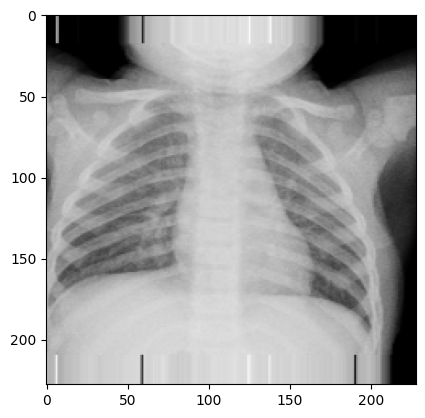


1/1 [==============================] - 0s 21ms/step
NORMAL


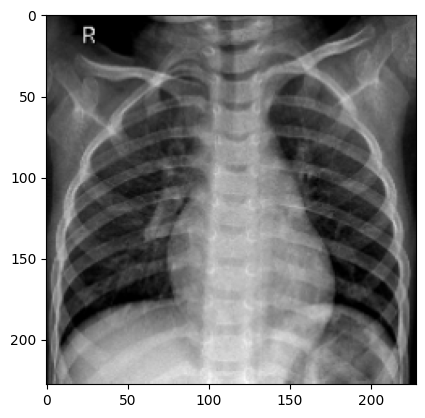


1/1 [==============================] - 0s 21ms/step
PNEUMONIA


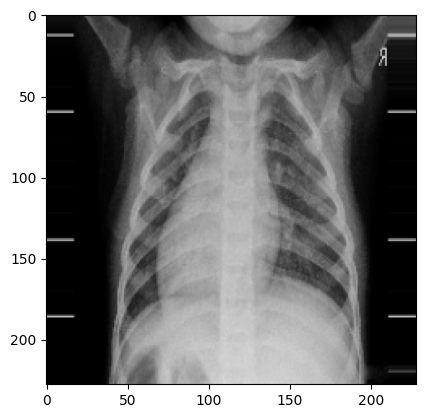


1/1 [==============================] - 0s 22ms/step
PNEUMONIA


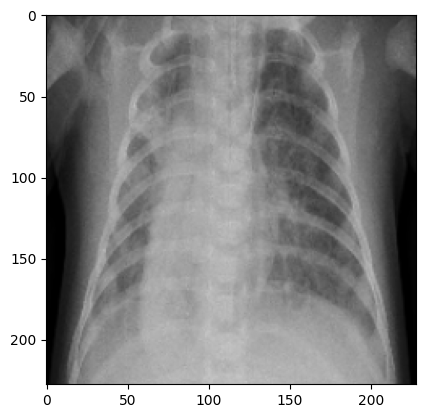


1/1 [==============================] - 0s 22ms/step
NORMAL


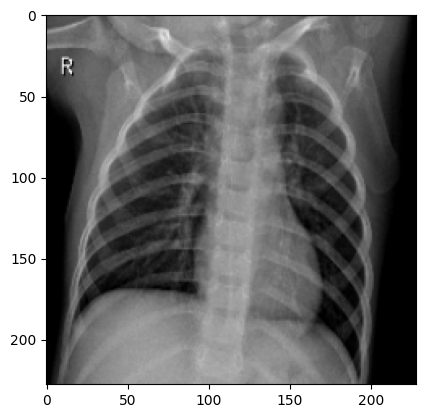

In [29]:

# Validation generator with batch size = 1 

generators['val'].batch_size = 1

# Preview examples from validation set and labels predicted from baseline model
for _ in range(5):
    x = next(generators['val'])[0]
    if altmodel.predict(x)[0][0] > 0.7:
        print('PNEUMONIA')
    elif altmodel.predict(x)[0][0] < 0.3:
        print('NORMAL')
    else:
        print('UNDECIDED')
    matplotlib.pyplot.imshow(x.reshape(MODEL_INPUT_SHAPE))
    matplotlib.pyplot.show()
    print()

In [17]:
# Build classifier on top of  VGG19
model = tf.keras.models.Sequential()

# Add dense layers on top of VGG19 
# 1
model.add(tf.keras.layers.Dense(256, activation='relu', input_dim=reshape_y))
# 2
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Compile
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(dataset['features']['train'], dataset['labels']['train'],
                    epochs=DEFAULT_EPOCHS,
                    batch_size=16,
                    validation_data=(dataset['features']['val'], dataset['labels']['val']))

# Save VGG19 results
model.save('models/model_VGG_01.keras')

Epoch 1/20
63/63 [==============================] - 2s 25ms/step - loss: 0.3648 - acc: 0.8510 - val_loss: 0.4146 - val_acc: 0.8125
Epoch 2/20
63/63 [==============================] - 1s 22ms/step - loss: 0.1421 - acc: 0.9530 - val_loss: 1.3476 - val_acc: 0.5625
Epoch 3/20
63/63 [==============================] - 1s 23ms/step - loss: 0.1277 - acc: 0.9430 - val_loss: 1.2150 - val_acc: 0.5625
Epoch 4/20
63/63 [==============================] - 2s 24ms/step - loss: 0.1038 - acc: 0.9510 - val_loss: 1.7802 - val_acc: 0.5625
Epoch 5/20
63/63 [==============================] - 2s 24ms/step - loss: 0.0816 - acc: 0.9690 - val_loss: 0.2192 - val_acc: 0.9375
Epoch 6/20
63/63 [==============================] - 2s 25ms/step - loss: 0.0646 - acc: 0.9750 - val_loss: 0.3753 - val_acc: 0.7500
Epoch 7/20
63/63 [==============================] - 2s 24ms/step - loss: 0.0589 - acc: 0.9790 - val_loss: 0.2381 - val_acc: 0.9375
Epoch 8/20
63/63 [==============================] - 1s 23ms/step - loss: 0.0482 - a

In [41]:
images = []
INPUT_SIZE=(228,228) # use the same pixel h * w target size for all images processed
MODEL_INPUT_SHAPE=(228,228,3)

images.append("{}/{}/{}/{}".format(dataset_root, 'val', 'NORMAL', 'NORMAL2-IM-1427-0001.jpeg'))
images.append("{}/{}/{}/{}".format(dataset_root, 'val', 'PNEUMONIA', 'person1946_bacteria_4874.jpeg'))

for image_path in images:
    img = tf.keras.preprocessing.image.load_img(image_path)  # this is a PIL image
    x = tf.keras.preprocessing.image.img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
    x = x.reshape((1,) + INPUT_SIZE)  # this is a Numpy array with shape (1, 3, 150, 150)
    
#    reshape_y = 7 * 7 * 512
#    dataset['features'][folder] = numpy.reshape(dataset['features'][folder], (len(dataset['features'][folder]), reshape_y))

    
    if altmodel.predict(x)[0][0] > 0.7:
        print('PNEUMONIA - {}'.format(image_path))
    elif altmodel.predict(x)[0][0] < 0.3:
        print('NORMAL - {}'.format(image_path))
    else:
        print('UNDECIDED - {}'.format(image_path))


ValueError: cannot reshape array of size 7544448 into shape (1,228,228)